In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import cv2imshow

In [3]:
template = cv.imread('template_pcb.jpg')
test_img = cv.imread('defected_pcb.jpg')

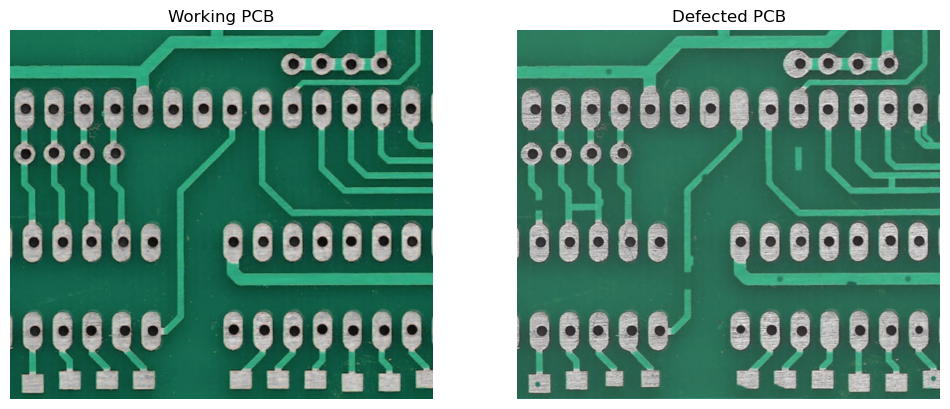

In [5]:
test_img = cv.imread('defected_pcb.jpg')
template_img = cv.imread('template_pcb.jpg')

f, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(cv.cvtColor(template_img, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].title.set_text('Working PCB')

ax[1].imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].title.set_text('Defected PCB')

In [7]:
def plotting_image(template,template_title:str,test_img,test_title:str):
    fig,ax = plt.subplots(1,2,figsize=(10,8))
    ax[0].imshow(template,cmap='grey')
    ax[0].axis('off')
    ax[0].set_title(f"{template_title}")

    ax[1].imshow(test_img,cmap='grey')
    ax[1].axis('off')
    ax[1].set_title(f"{test_title}")

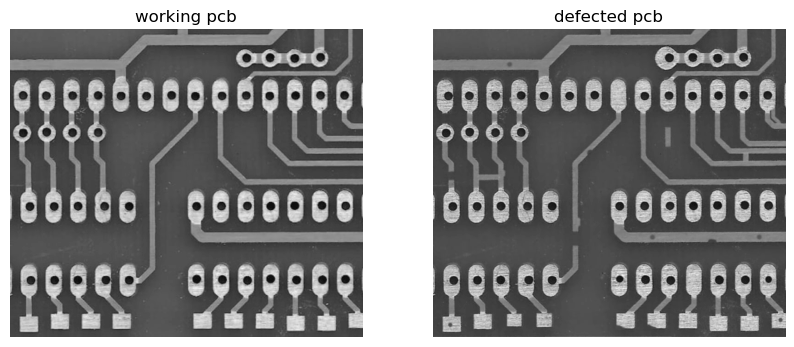

In [9]:
gray_test_img = cv.cvtColor(test_img,cv.COLOR_BGR2GRAY)
gray_template_img = cv.cvtColor(template_img,cv.COLOR_BGR2GRAY)
plotting_image(template=gray_template_img,template_title="working pcb",test_img=gray_test_img,test_title="defected pcb")

plotting histogram of the two pcb

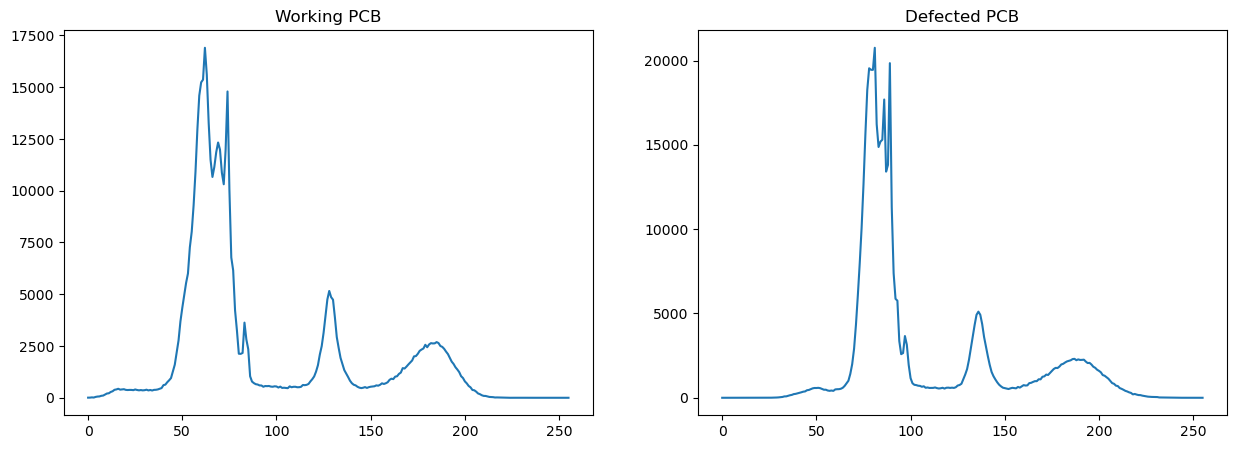

In [12]:
hist_test = cv.calcHist([gray_test_img],[0],None,[256],[0,256])
hist_template = cv.calcHist([gray_template_img],[0],None,[256],[0,256])

f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(hist_template)
ax[0].title.set_text('Working PCB')

ax[1].plot(hist_test)
ax[1].title.set_text('Defected PCB')

# Image Preprocessing

removing noise

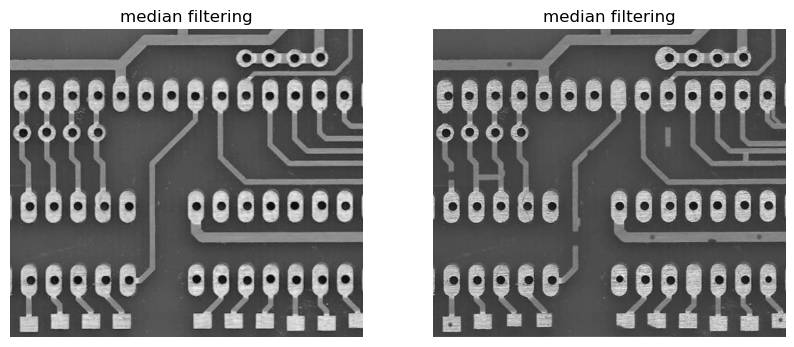

In [18]:
median_test = cv.medianBlur(gray_test_img,7)
median_template = cv.medianBlur(gray_template_img,7)
plotting_image(template=gray_template_img,template_title="median filtering",test_img=gray_test_img,test_title="median filtering")

gaussain filtering -> to suppress high intensity variation within image

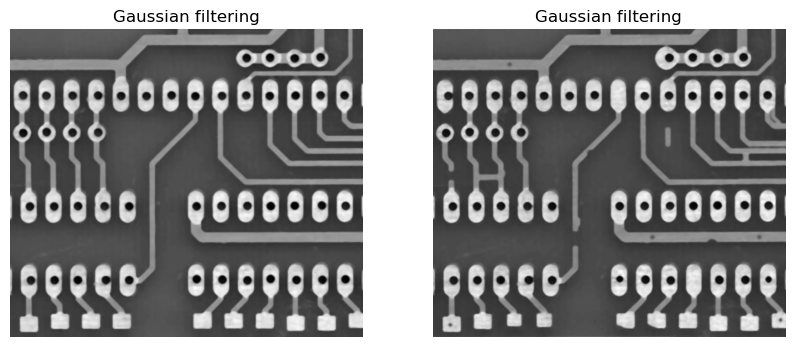

In [30]:
gauss_test = cv.GaussianBlur(median_test,ksize=(3,3),sigmaX=1)
gauss_template = cv.GaussianBlur(median_template,ksize=(3,3),sigmaX=1)
plotting_image(template=gauss_template,template_title="Gaussian filtering",test_img=gauss_test,test_title="Gaussian filtering")

# Image segmentation

performing plotting on various segements
- soldering pods
- wire tracks
- image background

soldering pad segmentation

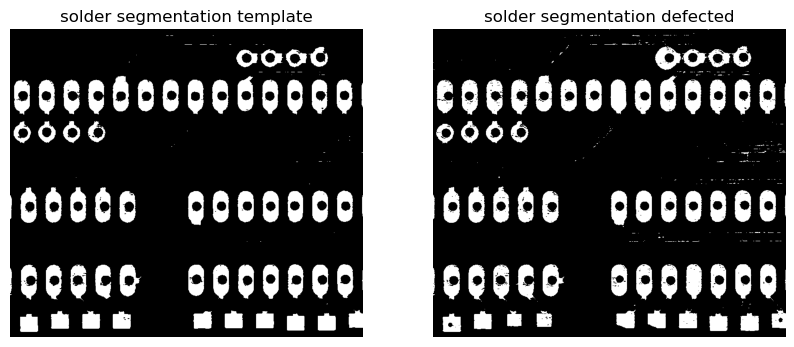

In [32]:
solder_test = cv.inRange(gray_test_img,147,255)
solder_template = cv.inRange(gray_template_img,145,255)
plotting_image(template=solder_template,template_title="solder segmentation template",test_img=solder_test,test_title="solder segmentation defected")

wire tracks

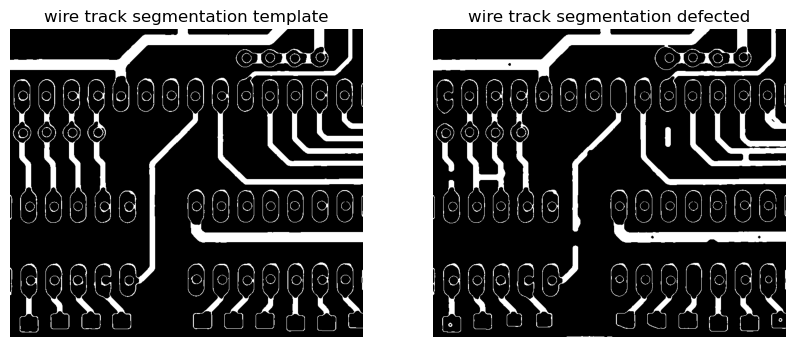

In [35]:
wire_test = cv.inRange(gauss_test,105,150)
wire_template = cv.inRange(gauss_template,95,145)
plotting_image(template=wire_template,template_title="wire track segmentation template",test_img=wire_test,test_title="wire track segmentation defected")

above plot contains some part from the soldering pad 
to remove the noise we perform open operation

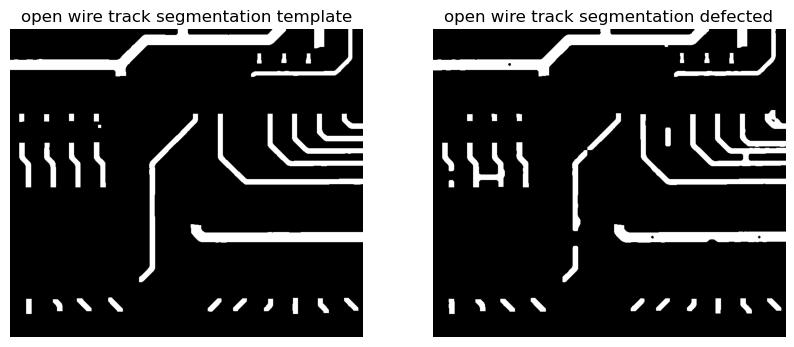

In [42]:
kernel = np.ones((7,7))
open_wire_test = cv.morphologyEx(wire_test,cv.MORPH_OPEN,kernel)
open_wire_template = cv.morphologyEx(wire_template,cv.MORPH_OPEN,kernel)
plotting_image(template=open_wire_template,template_title="open wire track segmentation template",test_img=open_wire_test,test_title="open wire track segmentation defected")

background image

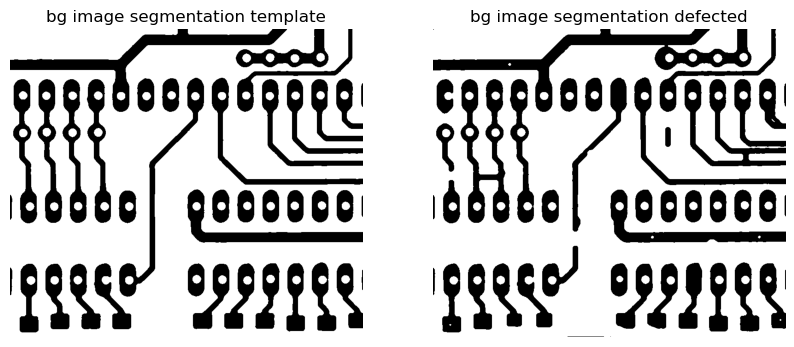

In [45]:
bg_test = cv.inRange(gauss_test,0,105)
bg_template = cv.inRange(gauss_template,0,95)
plotting_image(template=bg_template,template_title="bg image segmentation template",test_img=bg_test,test_title="bg image segmentation defected")

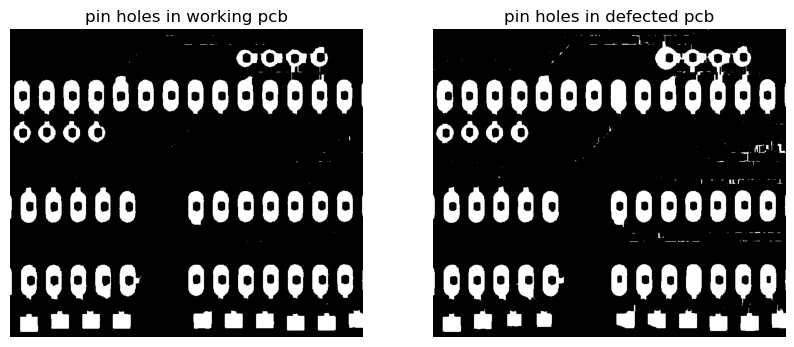

In [47]:
kernel = np.ones((13,3))
closed_solder_test = cv.morphologyEx(solder_test,cv.MORPH_CLOSE,kernel)
closed_solder_template = cv.morphologyEx(solder_template,cv.MORPH_CLOSE,kernel)
plotting_image(closed_solder_template,"pin holes in working pcb",closed_solder_test,"pin holes in defected pcb")

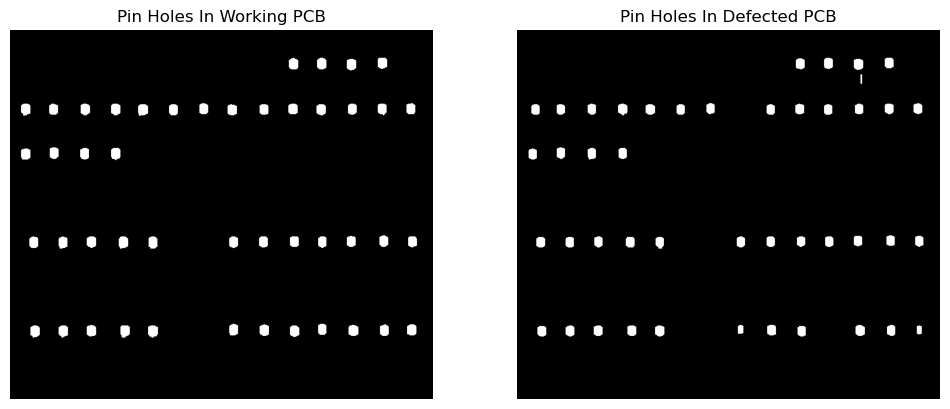

In [73]:

sold_test_fill = closed_solder_test.copy()
sold_template_fill = closed_solder_template.copy()

h, w = sold_test_fill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv.floodFill(sold_test_fill, mask, (0,0), 255);
hole_test = cv.bitwise_not(sold_test_fill)

h, w = sold_template_fill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv.floodFill(sold_template_fill, mask, (0,0), 255);
hole_template = cv.bitwise_not(sold_template_fill)

f, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(hole_template,cmap='gray')
ax[0].axis('off')
ax[0].title.set_text('Pin Holes In Working PCB')

ax[1].imshow(hole_test,cmap='gray')
ax[1].axis('off')
ax[1].title.set_text('Pin Holes In Defected PCB')

# Detecting defect

- pd - positive defect
- nd - negative defect

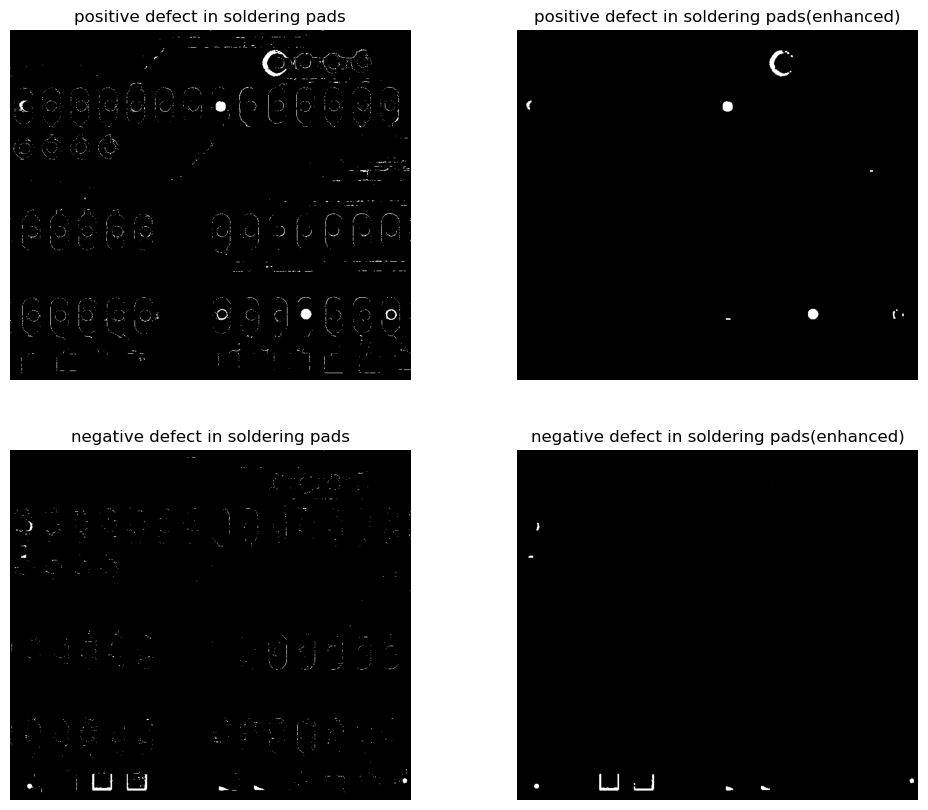

In [61]:
pd_solder = solder_test - solder_template
nd_solder = solder_template - solder_test

kernel = np.ones((3,3))
open_pd_solder = cv.morphologyEx(pd_solder, cv.MORPH_OPEN, kernel)
open_nd_solder = cv.morphologyEx(nd_solder, cv.MORPH_OPEN, kernel)

def defect_plot(pd,title1:str,nd,title2:str,open_pd,title3:str,open_nd,title4:str):
    f, ax = plt.subplots(2,2,figsize=(12,10))
    ax[0][0].imshow(pd_solder,cmap='gray')
    ax[0][0].axis('off')
    ax[0][0].title.set_text(f"{title1}")
    
    ax[1][0].imshow(nd_solder,cmap='gray')
    ax[1][0].axis('off')
    ax[1][0].title.set_text(f"{title2}")
    
    ax[0][1].imshow(open_pd_solder,cmap='gray')
    ax[0][1].axis('off')
    ax[0][1].title.set_text(f"{title3}")
    
    ax[1][1].imshow(open_nd_solder,cmap='gray')
    ax[1][1].axis('off')
    ax[1][1].title.set_text(f"{title4}")

defect_plot(pd_solder,'positive defect in soldering pads',
           nd_solder,'negative defect in soldering pads',
           open_pd_solder,'positive defect in soldering pads(enhanced)',
           open_nd_solder,'negative defect in soldering pads(enhanced)')

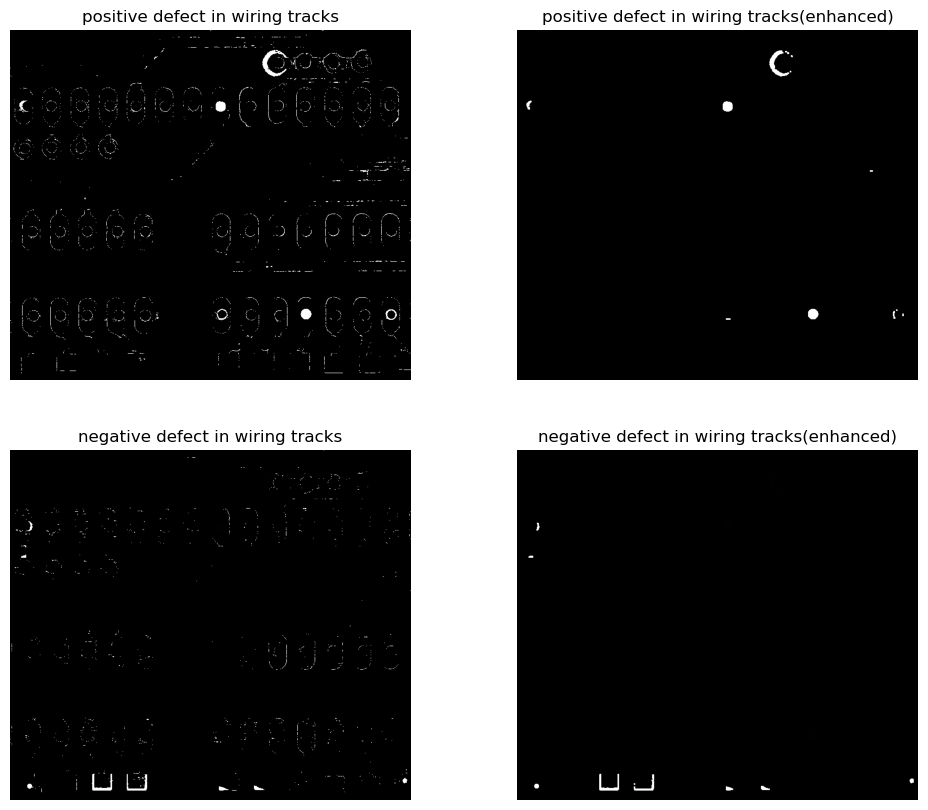

In [65]:
pd_wire = open_wire_test - open_wire_template
nd_wire = open_wire_template - open_wire_test

kernel = np.ones((3,3))
open_pd_wire = cv.morphologyEx(pd_wire, cv.MORPH_OPEN, kernel)
open_nd_wire = cv.morphologyEx(nd_wire, cv.MORPH_OPEN, kernel)

defect_plot(pd_wire,'positive defect in wiring tracks',
           nd_wire,'negative defect in wiring tracks',
           open_pd_wire,'positive defect in wiring tracks(enhanced)',
           open_nd_wire,'negative defect in wiring tracks(enhanced)')

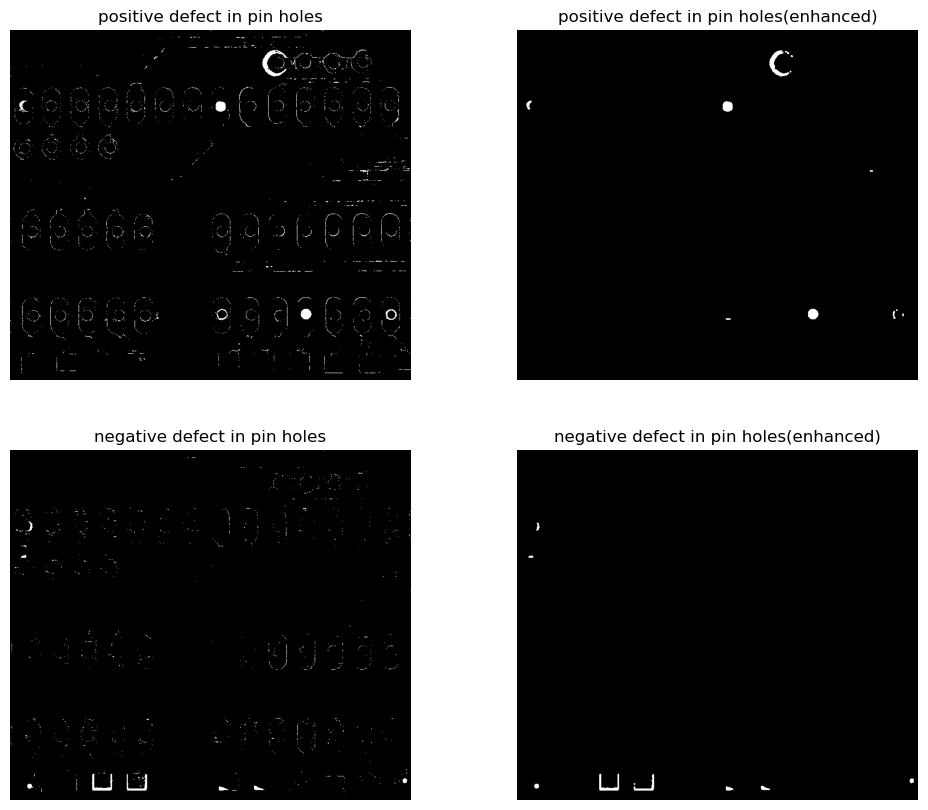

In [75]:
pd_hole = hole_test - hole_template
nd_hole = hole_template - hole_test
kernel = np.ones((3,3))
open_pd_hole = cv.morphologyEx(pd_hole, cv.MORPH_OPEN, kernel)
open_nd_hole = cv.morphologyEx(nd_hole, cv.MORPH_OPEN, kernel)
defect_plot(pd_hole,'positive defect in pin holes',
           nd_hole,'negative defect in pin holes',
           open_pd_hole,'positive defect in pin holes(enhanced)',
           open_nd_hole,'negative defect in pin holes(enhanced)')

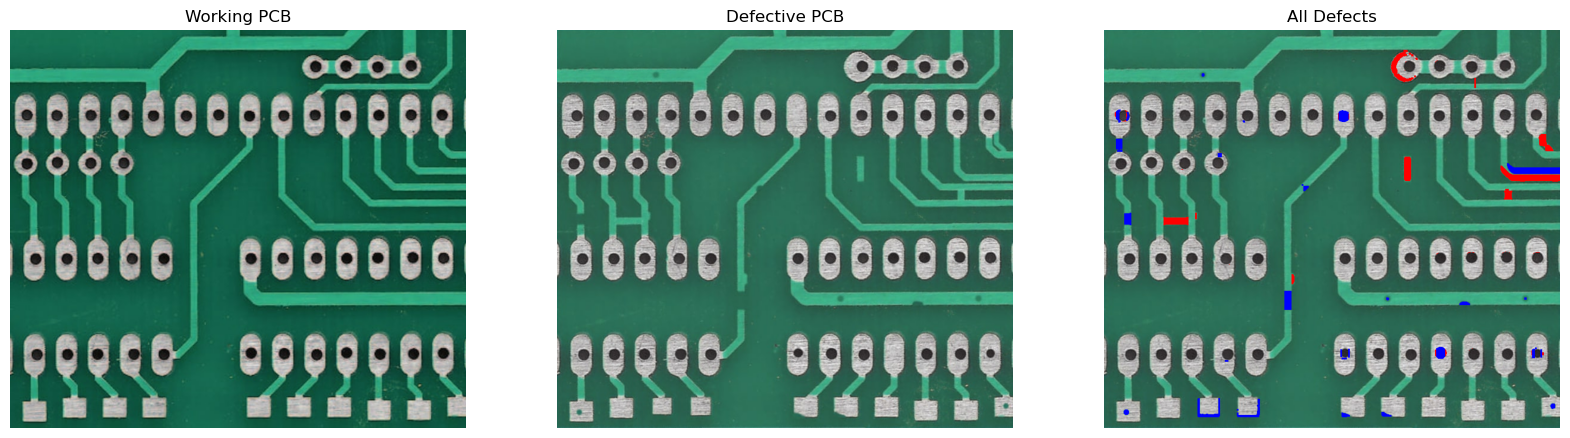

In [79]:
defects = test_img.copy()

defects[open_pd_solder == 255] = [0, 0, 255]
defects[open_pd_wire == 255] = [0, 0, 255]
defects[pd_hole == 255] = [0, 0, 255]

defects[open_nd_solder == 255] = [255, 0, 0]
defects[open_nd_wire == 255] = [255, 0, 0]
defects[open_nd_hole == 255] = [255, 0, 0]

f, ax = plt.subplots(1,3,figsize=(20,10))

ax[0].imshow(cv.cvtColor(template_img,cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].title.set_text('Working PCB')

ax[1].imshow(cv.cvtColor(test_img,cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].title.set_text('Defective PCB')

ax[2].imshow(cv.cvtColor(defects,cv.COLOR_BGR2RGB))
ax[2].axis('off')
ax[2].title.set_text('All Defects')